# Definition and Analysis of Image Quality Assessments (IQA)

### Abstract

In this essay, the primary objective image quality measures are reviewed. Many image processing applications, including picture restoration, compression, acquisition, enhancement, and others, heavily rely on these metrics. Modern methodologies aim to establish the optimum balance between performance, complexity, and results that are closest to the Human Visual System. This work collects and groups reported quality measures according to their tactics and techniques and proposes a novel way for RGB pictures.

In [1]:
# imports
import numpy as np # used for calculations between matrix (images)
import cv2 # computer vision library
import matplotlib.pyplot as plt # used for plotting images and diagramas
# as we are running code in Jupyter notebook
%matplotlib inline  

### Utlities

In [2]:
# PATHS
reference_images_path = 'data/reference_images/'
distorted_images_path = 'data/distorted_images/'

In [3]:
# utils function used to check if original and distorted images have same size and same extension otherwise IQA can't be computed
# O and D are images/np.arrays
def check_images(O, D):
    if O.dtype != D.dtype:
        print("Original and Distorted images have different extensions")
        return False
    if O.shape != D.shape:
        print("Original and Distorted images have different shapes")
        return False
    return True


# computes the similiraty between two given matrix - C is used for stability and avoid dividing by zero
def similarity_function(X, Y, C):
    return ((2*X*Y+C)/(X**2+Y**2+C))

## 1. Objective Metrics - Mathematical Metrics

In [4]:
# MSE: measures the average of the squares of the errors
# the average squared difference between the estimated values and the actual value
# INPUT PARAMS: O (original image), D (distorted image) 
def mse(O, D): 
    if check_images(O, D):
        return np.mean((O.astype(np.float64) - D.astype(np.float64))**2) # as we calculate the mean error float gives better performances
    else:
        return None

In [5]:
# RMSE: root square of MSE
def rsme(O, D):
    if check_images(O, D):
        return np.sqrt(mse(O, D))
    else:
        return None

In [6]:
# RSME SLIDIND WINDOW: compute the RSME using a ws*ws sliding window
# INPUT PARAMS: O (original image), D (distorted image), ws (sliding window size)
def rmse_sw(O, D, ws):
    O = O.astype(np.float64)
    D = D.astype(np.float64)
    window = np.ones((ws, ws), dtype=np.float64)/ws**2 # mean filter
    rmse = np.sqrt(cv2.filter2D((O - D)**2, -1, window)) # convolves an image with the kernel
    
    # to avoid edge effects will ignore filter radius strip around edges
    pad = round((ws - 1) / 2)
    return np.mean(rmse[pad:-pad,pad:-pad])

In [7]:
# PSNR: measure similar to MSE espressed in decibels
# higher the value of PSNR, the better will be the quality of the output image
# INPUT PARAMS: O (original image), D (distorted image) 
def psnr(O, D, MAX = False):
    if check_images(O, D):
        if MAX:
            return 10 * np.log10(np.max(O)**2 / mse(O, D))
        return 10 * np.log10(255**2 / mse(O, D))
    else:
        return None

## 2. Objective Metrics - Human Visual Systems (HVS)

In [8]:
# SSIM: structural similarity -> measure quality by capturing the similarity of images
# similarity in luminance, contrast and structure
# INPUT PARAMS: O (original image), D (distorted image)  ws (sliding window size)
# K1 & K2 are used to compute C1 and C2 which provide stability and avoid dividing for 0
# MAX if True uses the max intensity of the original image otherwise default is 255
# Gaussian if True apply a Gaussian filter instead of mean filter (sometimes used in the literature) (default True)
# cs if True return a parameter used in the MS-SSIM measure
# _essim if True return a parameter used in the ESSIM measure
def ssim(O, D, ws, K1 = 0.01, K2 = 0.02, MAX = False, Gaussian = True, cs = False, _essim = False):
    if check_images(O, D):
        O_gray = cv2.cvtColor(O, cv2.COLOR_BGR2GRAY).astype(np.float64)
        D_gray = cv2.cvtColor(D, cv2.COLOR_BGR2GRAY).astype(np.float64)
        
        if MAX:
            m = np.max(O_gray)
        else:
            m = 255
        C1 = (K1 * m) ** 2
        C2 = (K2 * m) ** 2
        
        if Gaussian:
            # 1D kernel
            kernel = cv2.getGaussianKernel(ws, round(ws/3.0) - 1) # the interval [-3sigma,+3 sigma] captures 99% of the area of the Faussian function
            # 2D kernel
            window = np.outer(kernel, kernel.transpose()) # compute the outer product of two vectors.
        else:
            window = np.ones((ws, ws), dtype=np.float64)/ws**2
        pad = round((ws - 1) / 2)

        mu_x = cv2.filter2D(O_gray, -1, window)[pad:-pad,pad:-pad]
        mu_y = cv2.filter2D(D_gray, -1, window)[pad:-pad,pad:-pad]
        squared_sigma_x = cv2.filter2D(O_gray**2, -1, window)[pad:-pad,pad:-pad] - mu_x**2
        squared_sigma_y = cv2.filter2D(D_gray**2, -1, window)[pad:-pad,pad:-pad] - mu_y**2
        sigma_x_y = cv2.filter2D(O_gray * D_gray, -1, window)[pad:-pad,pad:-pad] - (mu_x * mu_y)
        if _essim:
            sigma_x = cv2.filter2D(O_gray, -1, window)[pad:-pad,pad:-pad] - mu_x
            sigma_y = cv2.filter2D(D_gray, -1, window)[pad:-pad,pad:-pad] - mu_y
            luminance = (2 * mu_x * mu_y + C1)/(mu_x**2 + mu_y**2 + C1)
            contrast = (2 * sigma_x * sigma_y + C1)/(sigma_x**2 + sigma_y**2 + C2)
            return np.mean(luminance), np.mean(contrast)
        ssim_map = ((2 * mu_x * mu_y + C1) * (2 * sigma_x_y + C2)) / ((mu_x**2 + mu_y**2 + C1) * (squared_sigma_x + squared_sigma_y + C2))
        cs_map = (2*sigma_x_y + C2)/(squared_sigma_x + squared_sigma_y + C2)
        if cs:
            return np.mean(ssim_map), np.mean(cs_map)
        return np.mean(ssim_map)
    else:
        return None

In [9]:
# MS-SSIM: multi scale structural similarity (more flexible than SSIM)
# The original and the distorted or noisy images are iteratively low-pass filtered 
# INPUT PARAMS: O (original image), D (distorted image),  ws (sliding window size), weights each scale importance (default: [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
# Gaussian if True apply a Gaussian filter instead of mean filter for low-pass filtering (default True)
def ms_ssim(O, D, ws,
            weights = np.array([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]),
            Gaussian = True):
    if check_images(O, D):
        level = len(weights)
        O_gray = cv2.cvtColor(O, cv2.COLOR_BGR2GRAY).astype(np.float64)
        D_gray = cv2.cvtColor(D, cv2.COLOR_BGR2GRAY).astype(np.float64)
        mssim = np.array([], dtype=np.float64)
        mcs = np.array([], dtype=np.float64)
        
        if Gaussian:
            # 1D kernel
            kernel = cv2.getGaussianKernel(ws, round(ws/3.0) - 1) # the interval [-3sigma,+3 sigma] captures 99% of the area of the Faussian function
            # 2D kernel
            window = np.outer(kernel, kernel.transpose()) # compute the outer product of two vectors.
        else:
            window = np.ones((ws, ws), dtype=np.float64)/ws**2 # mean filter
        pad = round((ws - 1) / 2)
        
        mu_x = cv2.filter2D(O_gray, -1, window)[pad:-pad,pad:-pad]
        mu_y = cv2.filter2D(D_gray, -1, window)[pad:-pad,pad:-pad]
        C1 = 0.01 # default
        luminance = (2 * mu_x * mu_y + C1)/(mu_x**2 + mu_y**2 + C1)
        
        for l in range(level):
            _ssim, _cs = ssim(O, D, ws, cs = True)
            mssim = np.append(mssim, _ssim)
            mcs = np.append(mcs, _cs)
            
            filtrered_O_gray = cv2.filter2D(O_gray, -1, window) # low - passed
            filtrered_D_gray = cv2.filter2D(D_gray, -1, window) # low - passed
            
            O_gray = filtrered_O_gray[::2,::2] # down-sampling by 2
            D_gray = filtrered_D_gray[::2,::2] # down-sampling by 2

        return np.mean(luminance*np.prod(mcs[:level-1]**weights[:level-1])*(mssim[level-1]**weights[level-1]))        
    else:
        return None

In [10]:
# Compute the edge direction histogram following the (1), (2) and (3) step described below
# show_image if True shows the edge direction histogram for the passed Image
def get_direction_histogram_vector(name, magnitude, orientation, histogram_size, show_image = False):
    direction_histogram_vector = np.zeros(histogram_size + 1)
    for i in range(orientation.shape[0] - 1):
        for j in range(orientation.shape[1] - 1):
            idx = round(orientation[i][j]/ 180.0 * histogram_size) # find dicrete level
            direction_histogram_vector[idx] = direction_histogram_vector[idx] + magnitude[i][j] # accumulate pixels based on orientation
    
    if show_image:
        values = np.array([])
        for i in range(histogram_size + 1):
            values = np.append(values, i)

        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True
        plt.title(f'Direction Histogram Vector for {name}')
        plt.xlabel('Edge amplitudes with the same direction')
        plt.ylabel('Orientation discrete direction ranges');
        plt.bar(values, direction_histogram_vector)

        plt.show()
    
    return direction_histogram_vector

In [11]:
# ESSIM: edge-based structural similarity (Sobel as convolutional operator -- alternative: Scharr)
# Compares the edge information between the distorted image block and the original one
# then replace the structure comparison by the edge-based structure comparison
# INPUT PARAMS: O (original image), D (distorted image),  ws (sliding window size)
# histogram_size stands for number of discrete levels in which the continual direction (0-180 grades) is divided (default = 8)
# show_image if True shows the grayscale, gradient magnitude, and gradient orientation images to the plot
def essim(O, D, histogram_size = 8, C3 = 0.03, show_image = False):
    luminance, contrast = ssim(O, D, 11, _essim = True)
    O_gray = cv2.cvtColor(O, cv2.COLOR_BGR2GRAY)
    D_gray = cv2.cvtColor(D, cv2.COLOR_BGR2GRAY)
    
    # compute gradients along the x and y axis, respectively
    O_gX = cv2.Sobel(O_gray, cv2.CV_64F, 1, 0)
    O_gY = cv2.Sobel(O_gray, cv2.CV_64F, 0, 1)
    # compute the gradient magnitude and orientation
    O_magnitude = np.sqrt((O_gX ** 2) + (O_gY ** 2))
    O_orientation = np.arctan2(O_gY, O_gX) * (180 / np.pi) % 180
    
    D_gX = cv2.Sobel(D_gray, cv2.CV_64F, 1, 0)
    D_gY = cv2.Sobel(D_gray, cv2.CV_64F,  0, 1)
    # 1) Calculate each pixel’s edge amplitude and direction
    D_magnitude = np.sqrt((D_gX ** 2) + (D_gY ** 2))
    D_orientation = np.arctan2(D_gY, D_gX) * (180 / np.pi) % 180
    
    if show_image:
        (fig, axs) = plt.subplots(2, 3, figsize=(8, 4))
        fig.tight_layout()
        axs[0][0].imshow(O_gray, cmap="gray")
        axs[0][0].set_title("Grayscale")
        axs[0][1].imshow(O_magnitude, cmap="jet")
        axs[0][1].set_title("Gradient Magnitude")
        axs[0][2].imshow(O_orientation, cmap="jet")
        axs[0][2].set_title("Gradient Orientation [0, 180]")

        axs[1][0].imshow(D_gray, cmap="gray")
        axs[1][1].imshow(D_magnitude, cmap="jet")
        axs[1][2].imshow(D_orientation, cmap="jet")

        for i in range(0, 2):
            for j in range(0, 3):
                axs[i][j].get_xaxis().set_ticks([])
                axs[i][j].get_yaxis().set_ticks([])

        # show the plots
        plt.tight_layout()
        plt.show()
    
    
    # 2)  Quantify each pixel’s direction as one of the histogram_size discrete directions
    # 3) Sum up all the pixels’ edge amplitudes with the same direction in the block.
    x_direction_histogram_vector = get_direction_histogram_vector('Original Image', O_magnitude, O_orientation, histogram_size, show_image)
    y_direction_histogram_vector = get_direction_histogram_vector('Distorted Image', D_magnitude, D_orientation, histogram_size, show_image)
    
    sigma_x = np.std(x_direction_histogram_vector)
    sigma_y = np.std(y_direction_histogram_vector)
    sigma_x_y = np.mean(x_direction_histogram_vector * y_direction_histogram_vector) - np.mean(x_direction_histogram_vector) * np.mean(y_direction_histogram_vector)
    return luminance*contrast*((sigma_x_y + C3)/ (sigma_x * sigma_y + C3))

In [12]:
# Converts an RGB image to YIQ color space
# :param imgRGB: An Image in RGB
# :return: A YIQ in image color space
def transformRGB2YIQ(imgRGB):
    yiq_from_rgb = np.array([[0.299, 0.587, 0.114],
                             [0.59590059, -0.27455667, -0.32134392],
                             [0.21153661, -0.52273617, 0.31119955]])
    shape = imgRGB.shape
    return np.dot(imgRGB.reshape(-1,3), yiq_from_rgb.transpose()).reshape(shape)

In [13]:
from skimage import io, color, data

In [14]:
# A new similiraty method based on ESSIM which deals with the influence of colors when dealing in finding similiraty between two images
# INPUT PARAMS: O (original image), D (distorted image),  ws (sliding window size)
# histogram_size stands for number of discrete levels in which the continual direction (0-180 grades) is divided (default = 8)
# C3, T3 & T4 are default parameters used for stability and avoid dividing by 0
# show_image if True shows the grayscale, luminance, and chrominance images to the plot
def essim_colors_method(O, D, histogram_size = 8, C3 = 0.03, T3 = 0.001, T4 = 0.001, display_images = False):
    
    # convert the original RGB color images into YIQ color space
    # Y: the luminance information
    # I and Q convey the chrominance information
    # I: in-phase information
    # Q: quadrature representing the color information
    if O.ndim == 3: # naive method to check if O is a RGB image
        # img_YIQ = transformRGB2YIQ(O) -> skiimage method more efficient
        O_img_YIQ = color.rgb2yiq(O)
        #io.imshow(O_img_YIQ)
        O_Y = O_img_YIQ[:,:,0]
        O_I = O_img_YIQ[:,:,1]
        O_Q = O_img_YIQ[:,:,2]
        D_img_YIQ = color.rgb2yiq(D)
        D_Y = D_img_YIQ[:,:,0]
        D_I = D_img_YIQ[:,:,1]
        D_Q = D_img_YIQ[:,:,2]
        

        if display_images:
            fig, axs = plt.subplots(2, 3, figsize=(8, 4))
            axs[0][0].set_title("O_Y")
            axs[0][0].imshow(O_Y, cmap="gray")
            axs[1][0].set_title("D_Y")
            axs[1][0].imshow(D_Y, cmap="gray")
            axs[0][1].set_title("O_I")
            axs[0][1].imshow(O_I, cmap="jet")
            axs[1][1].set_title("D_I")
            axs[1][1].imshow(D_I, cmap="jet")
            axs[0][2].set_title("O_Q")
            axs[0][2].imshow(O_Q, cmap="jet")
            axs[1][2].set_title("D_Q")
            axs[1][2].imshow(D_Q, cmap="jet")

            for i in range(0, 2):
                for j in range(0, 3):
                    axs[i][j].get_xaxis().set_ticks([])
                    axs[i][j].get_yaxis().set_ticks([])
            plt.show()

        in_phase_similarity = similarity_function(O_I, D_I, T3)
        color_information_similarity = similarity_function(O_Q, D_Q, T4)
        _essim = essim(img_o, img_d)
        return np.mean(_essim*in_phase_similarity*color_information_similarity)

### 2.1 Find differences using SSIM

In [15]:
from skimage.metrics import structural_similarity

In [16]:
# Shows the difference between two images
# Credits: https://stackoverflow.com/questions/56183201/detect-and-visualize-differences-between-two-images-with-opencv-python
def difference_ssim(O, D):
    O_copy = O.copy()
    D_copy = D.copy()
    
    # Convert images to grayscale
    O_grey = cv2.cvtColor(O_copy, cv2.COLOR_BGR2GRAY)
    D_grey = cv2.cvtColor(D_copy, cv2.COLOR_BGR2GRAY)
    (score, diff) = structural_similarity(O_grey, D_grey, full=True)
    
    # The diff image contains the actual image differences between the two images
    # and is represented as a floating point data type in the range [0,1] 
    # so we must convert the array to 8-bit unsigned integers in the range
    # [0,255] before we can use it with OpenCV
    diff = (diff * 255).astype("uint8")
    
    # Threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    mask = np.zeros(O_copy.shape, dtype='uint8')
    result = D_copy.copy()
    for c in contours:
        area = cv2.contourArea(c)
        if area > 40:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(O_copy, (x, y), (x + w, y + h), (36,255,12), 2)
            cv2.rectangle(D_copy, (x, y), (x + w, y + h), (36,255,12), 2)
            cv2.drawContours(mask, [c], 0, (0,255,0), -1)
            cv2.drawContours(result, [c], 0, (0,255,0), -1)
    
    fig, axs = plt.subplots(1, 4, figsize=(8, 4))   
    axs[0].imshow(cv2.cvtColor(O_copy, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(D_copy, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Destination Image')
    axs[1].axis('off')

    axs[2].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Mask')
    axs[2].axis('off')

    axs[3].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axs[3].set_title('Result')
    axs[3].axis('off')
    plt.show()
    

## 3. Data Analysis

### 3.1 Load two images to test IQA functions

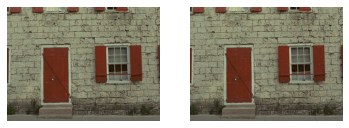

In [17]:
img_o = cv2.imread(reference_images_path + 'I01.BMP')
img_d = cv2.imread(distorted_images_path + 'I01_01_1.BMP')
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_d, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 3.2 Image Datset

In order to evaluate and compare the pripreviously developed IQA, I decided to use **TID2008** dataset which contains 1700 test images (25 reference images, 17 types of distortions for each reference image, 4 different levels of each type of distortion).

Moreover the quality of any image database highly depends on the reference images which have to represent a wide variety of scenes. For that reason, the database should include different textural characteristics, various percentage of homogeneous regions, edges, and details.

All images in the database are of size **512x384** pixels and are subject to the distortion described in the paper. 

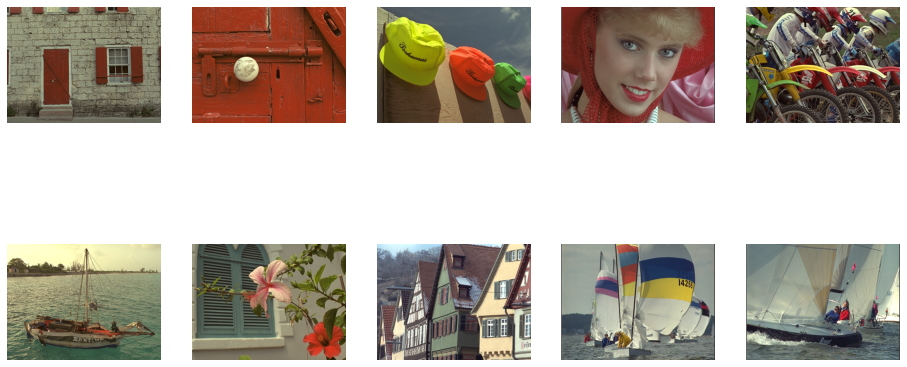

In [18]:
# first ten reference images
fig, axs = plt.subplots(2, 5, figsize=(16, 8))
w = 1
for i in range(0, 2):
    for j in range(0, 5):
        if w < 10:
            img = cv2.imread(reference_images_path + f'I0{w}.BMP')
        else:
            img = cv2.imread(reference_images_path + f'I{w}.BMP')
        w = w + 1
        axs[i][j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i][j].axis('off')

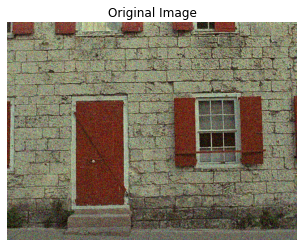

In [19]:
# first image and all relative distorted versions
img_o = cv2.imread('data/distorted_images/I01_01_4.bmp')
plt.axis('off')
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB))
plt.show()

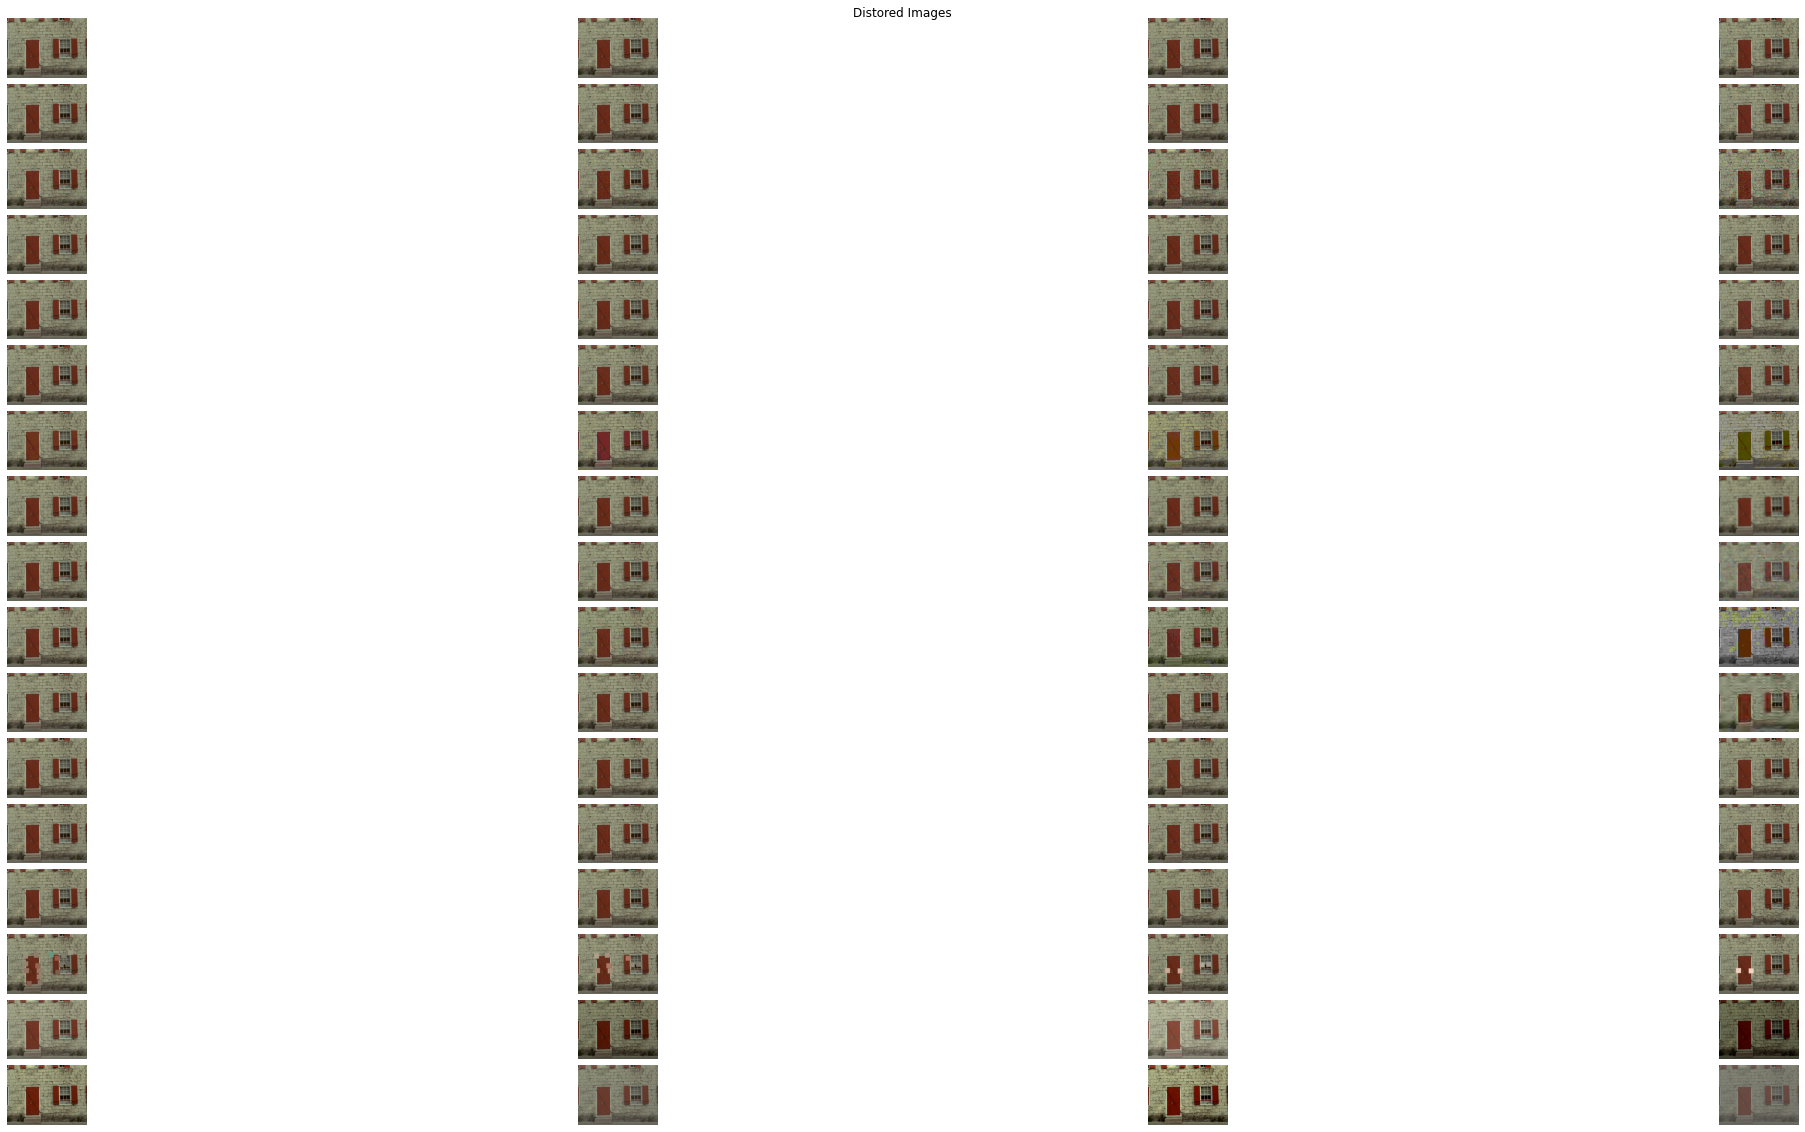

In [20]:
fig, axs = plt.subplots(17, 4, figsize=(32, 16))
fig.suptitle('Distored Images')
for i in range(1, 18):
    for j in range(1, 5):
        if i < 10:
            img = cv2.imread(distorted_images_path + f'I01_0{i}_{j}.BMP')
        else:
            img = cv2.imread(distorted_images_path + f'I01_{i}_{j}.BMP')
        axs[i-1,j-1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i-1,j-1].axis('off')
        axs[i-1,j-1].set_aspect('equal')
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)

## 4. Comparison and Tests

### 4.1 Using all set

In [21]:
# scatter plots between MOS and each IQA for each image of the dataset
# 1) Get MOS values from text file
file_name = 'data/mos_with_names.txt'
# Initialize empty arrays to store data
MOS_vector = np.array([], dtype=np.float64) # MOS value for each image
IMG_vector = [] # for each MOS value save the relative image name
with open(file_name) as f:
    lines = f.readlines() # line format: 4.8056 i01_03_1.bmp\n
    for line in lines:
        MOS_value = float(line.split(' ')[0])
        img_name = 'I' + line.split(' ')[1].split('i')[1].split("\n")[0]
        MOS_vector = np.append(MOS_vector, MOS_value)
        IMG_vector.append(img_name)

In [22]:
from pathlib import Path # used to check if a file exists

In [28]:
# Initialize empty arrays to store data for each IQA
MSE_vector = np.array([], dtype=np.float64)
PSNR_vector = np.array([], dtype=np.float64)
ERGAS_vector = np.array([], dtype=np.float64)
SSIM_vector = np.array([], dtype=np.float64)
MSSSIM_vector = np.array([], dtype=np.float64)
ESSIM_vector = np.array([], dtype=np.float64)
CESSIM_vector = np.array([], dtype=np.float64)

In [29]:
# Due to complex algorithms for an high number of samples, we compute results once and then save them into a file
# Leverage np.loadtxt and np.save primitive to respectively load and save results stored in arrays
if Path("results/mse_vector.txt").is_file():
    MSE_vector = np.loadtxt("results/mse_vector.txt")
if Path("results/psnr_vector.txt").is_file():
    PSNR_vector = np.loadtxt("results/psnr_vector.txt")
if Path("results/ssim_vector.txt").is_file():
    SSIM_vector = np.loadtxt("results/ssim_vector.txt")
if Path("results/msssim_vector.txt").is_file():
    MSSSIM_vector = np.loadtxt("results/msssim_vector.txt")
if Path("results/essim_vector.txt").is_file():
    ESSIM_vector = np.loadtxt("results/essim_vector.txt")
if Path("results/cessim_vector.txt").is_file():
    CESSIM_vector = np.loadtxt("results/cessim_vector.txt")

In [ ]:
for img in IMG_vector: 
    img_o = cv2.imread(reference_images_path + img.split('_')[0] + '.bmp') #resamble original image starting from the name of distorted image
    img_d = cv2.imread(distorted_images_path + img)
    
    MSE_vector = np.append(MSE_vector, mse(img_o, img_d))
    PSNR_vector = np.append(PSNR_vector, psnr(img_o, img_d))
    SSIM_vector = np.append(SSIM_vector, ssim(img_o, img_d, 7))
    MSSSIM_vector = np.append(MSSSIM_vector, ms_ssim(img_o, img_d, 7))
    ESSIM_vector = np.append(ESSIM_vector, essim(img_o, img_d))
    CESSIM_vector = np.append(CESSIM_vector, essim_colors_method(img_o, img_d))
    
if not Path("results/mse_vector.txt").is_file():
    np.save("results/mse_vector.txt", MSE_vector)
if not Path("results/psnr_vector.txt").is_file():
    np.save("results/psnr_vector.txt", PSNR_vector)
if not Path("results/ssim_vector.txt").is_file():
    np.save("results/ssim_vector.txt", SSIM_vector)
if not Path("results/msssim_vector.txt").is_file():
    np.save("results/msssim_vector.txt", MSSSIM_vector)
if not Path("results/essim_vector.txt").is_file():
    np.save("results/essim_vector.txt", ESSIM_vector)
if not Path("results/cessim_vector.txt").is_file():
    np.save("results/cessim_vector.txt", CESSIM_vector)

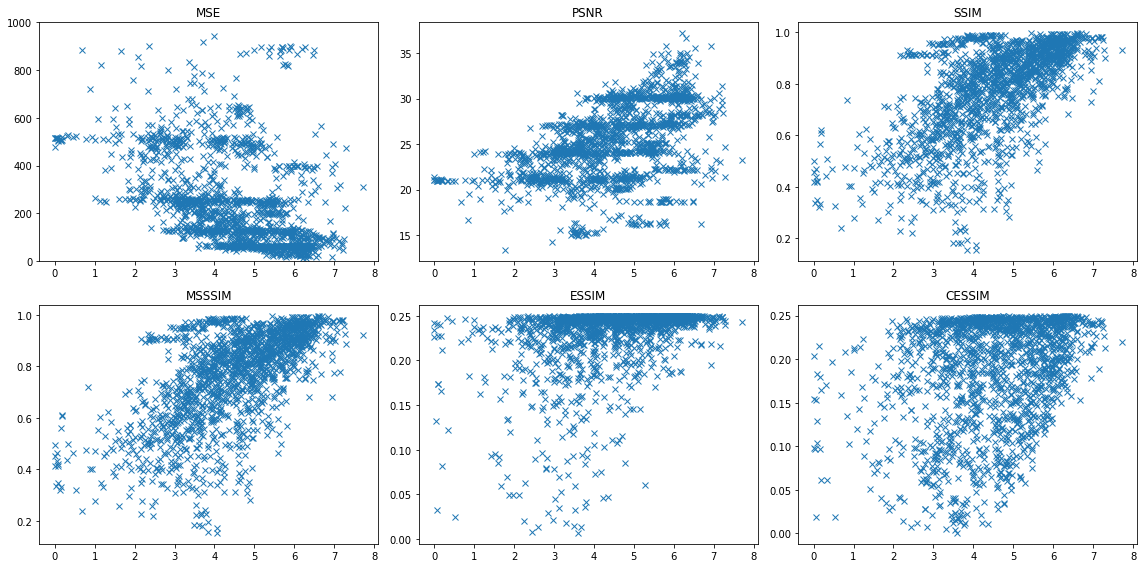

In [30]:
(fig, axs) = plt.subplots(2, 3, figsize=(16, 8))
fig.tight_layout()
axs[0][0].plot(MOS_vector, MSE_vector, "x")
axs[0][0].set_ylim(0, 1000)
axs[0][0].set_title("MSE")
axs[0][1].plot(MOS_vector, PSNR_vector, "x")
axs[0][1].set_title("PSNR")
axs[0][2].plot(MOS_vector, SSIM_vector, "x")
axs[0][2].set_title("SSIM")
axs[1][0].plot(MOS_vector, MSSSIM_vector, "x")
axs[1][0].set_title("MSSSIM")
axs[1][1].plot(MOS_vector, np.abs(ESSIM_vector), "x")
axs[1][1].set_title("ESSIM")
axs[1][2].plot(MOS_vector, np.abs(CESSIM_vector), "x")
axs[1][2].set_title("CESSIM")
plt.subplots_adjust(wspace=1, hspace=1)

# show the plots
plt.tight_layout()
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import rankdata

In [33]:
# cross correlation
CC_results = [] # used later for rank data
CC_MSE = np.corrcoef(MOS_vector, MSE_vector)
CC_results.append(CC_MSE[0][1])
CC_PNSR = np.corrcoef(MOS_vector, PSNR_vector)
CC_results.append(CC_PNSR[0][1])
CC_SSIM = np.corrcoef(MOS_vector, SSIM_vector)
CC_results.append(CC_SSIM[0][1])
CC_MSSSIM = np.corrcoef(MOS_vector, MSSSIM_vector)
CC_results.append(CC_MSSSIM[0][1])
CC_ESSIM = np.corrcoef(MOS_vector, ESSIM_vector)
CC_results.append(CC_ESSIM[0][1])
CC_CESSIM = np.corrcoef(MOS_vector, CESSIM_vector)
CC_results.append(CC_CESSIM[0][1])

In [34]:
# mean absolute error 
MAE_results = []
MAE_MSE = mean_absolute_error(MOS_vector, MSE_vector)
MAE_results.append(MAE_MSE)
MAE_PSNR = mean_absolute_error(MOS_vector, PSNR_vector)
MAE_results.append(MAE_PSNR)
MAE_SSIM = mean_absolute_error(MOS_vector, SSIM_vector)
MAE_results.append(MAE_SSIM)
MAE_MSSSIM = mean_absolute_error(MOS_vector, MSSSIM_vector)
MAE_results.append(MAE_MSSSIM)
MAE_ESSIM = mean_absolute_error(MOS_vector, ESSIM_vector)
MAE_results.append(MAE_ESSIM)
MAE_CESSIM = mean_absolute_error(MOS_vector, CESSIM_vector)
MAE_results.append(MAE_CESSIM)

In [35]:
# root mean squared error 
RMSE_results = []
RMSE_MSE = mean_squared_error(MOS_vector, MSE_vector)
RMSE_results.append(RMSE_MSE)
RMSE_PSNR = mean_squared_error(MOS_vector, PSNR_vector)
RMSE_results.append(RMSE_PSNR)
RMSE_SSIM = mean_squared_error(MOS_vector, SSIM_vector)
RMSE_results.append(RMSE_SSIM)
RMSE_MSSSIM = mean_squared_error(MOS_vector, MSSSIM_vector)
RMSE_results.append(RMSE_MSSSIM)
RMSE_ESSIM = mean_squared_error(MOS_vector, ESSIM_vector)
RMSE_results.append(RMSE_ESSIM)
RMSE_CESSIM = mean_squared_error(MOS_vector, CESSIM_vector)
RMSE_results.append(RMSE_CESSIM)

In [36]:
# outlier ratio: percentage of the number of predictions outside the range of ±2 times of the standard deviations
def compute_outlier_ratio(vector):
    outliers = 0
    
    threshold = 2
    mean = np.mean(vector)
    std =np.std(vector)
    for element in vector:
        z_score = (element - mean)/std
        if np.abs(z_score) > threshold:
            outliers += 1
    return outliers/len(vector)

In [37]:
# outliers ratio
OR_results = []
OR_MSE = compute_outlier_ratio(MSE_vector)
OR_results.append(OR_MSE)
OR_PSNR = compute_outlier_ratio(PSNR_vector)
OR_results.append(OR_PSNR)
OR_SSIM = compute_outlier_ratio(SSIM_vector)
OR_results.append(OR_SSIM)
OR_MSSSIM = compute_outlier_ratio(MSSSIM_vector)
OR_results.append(OR_MSSSIM)
OR_ESSIM = compute_outlier_ratio(ESSIM_vector)
OR_results.append(OR_ESSIM)
OR_CESSIM = compute_outlier_ratio(CESSIM_vector)
OR_results.append(OR_CESSIM)

In [38]:
# spearman rank-order correlation coefficient
# reference: https://realpython.com/numpy-scipy-pandas-correlation-python/
ROCC_results = []
ROCC_MSE = spearmanr(MOS_vector, MSE_vector).correlation
ROCC_results.append(ROCC_MSE)
ROCC_PSNR = spearmanr(MOS_vector, PSNR_vector).correlation
ROCC_results.append(ROCC_PSNR)
ROCC_SSIM = spearmanr(MOS_vector, SSIM_vector).correlation
ROCC_results.append(ROCC_SSIM)
ROCC_MSSSIM = spearmanr(MOS_vector, MSSSIM_vector).correlation
ROCC_results.append(ROCC_MSSSIM)
ROCC_ESSIM = spearmanr(MOS_vector, ESSIM_vector).correlation
ROCC_results.append(ROCC_ESSIM)
ROCC_CESSIM = spearmanr(MOS_vector, CESSIM_vector).correlation
ROCC_results.append(ROCC_CESSIM)

In [39]:
# Rank results
print(f"Ranked data for mean cross correlation: {rankdata(CC_results)}")
print(f"Ranked data for mean absolute error: {rankdata(MAE_results)}")
print(f"Ranked data for root mean square error: {rankdata(RMSE_results)}")
print(f"Ranked data for outlier ratio: {rankdata(OR_results)}")
print(f"Ranked data for spearman rank-order correlation coefficient: {rankdata(ROCC_results)}")

Ranked data for mean cross correlation: [1. 4. 5. 6. 3. 2.]
Ranked data for mean absolute error: [6. 5. 1. 2. 3. 4.]
Ranked data for root mean square error: [6. 5. 1. 2. 3. 4.]
Ranked data for outlier ratio: [1. 6. 4. 5. 3. 2.]
Ranked data for spearman rank-order correlation coefficient: [1. 4. 5. 6. 3. 2.]


### 4.2 Highly Blurred Images

In the next section, all previously calculation will be applied for highly blurred images subset of TID2008 dataset

In [40]:
# 1) Extract MOS value and image names for only highly blurred images
# From the dataset paper we know that blurred images have 8 as second index and as we are looking for 
# highly blurred images, the second parameter, indicating the intensity of the distortion, we should take value 3 and 4
# in a range of 1 to 4.

MOS_vector_blurred = np.array([], dtype=np.float64) # MOS value for each image
IMG_vector_blurred = [] # for each MOS value save the relative image name
with open(file_name) as f:
    lines = f.readlines() # line format: 4.8056 i01_03_1.bmp\n
    for line in lines:
        MOS_value = float(line.split(' ')[0])
        img_name = 'I' + line.split(' ')[1].split('i')[1].split("\n")[0]
        if img_name.split('_')[1] == '08' and (img_name.split('_')[2] == '3.bmp' or img_name.split('_')[2] == '4.bmp'):
            MOS_vector_blurred = np.append(MOS_vector_blurred, MOS_value)
            IMG_vector_blurred.append(img_name)

In [ ]:
# Initialize empty arrays to store data for each IQA
MSE_vector_blurred = np.array([], dtype=np.float64)
PSNR_vector_blurred = np.array([], dtype=np.float64)
ERGAS_vector_blurred = np.array([], dtype=np.float64)
SSIM_vector_blurred = np.array([], dtype=np.float64)
MSSSIM_vector_blurred = np.array([], dtype=np.float64)
ESSIM_vector_blurred = np.array([], dtype=np.float64)
CESSIM_vector_blurred = np.array([], dtype=np.float64)


for img in IMG_vector_blurred: 
    img_o = cv2.imread(reference_images_path + img.split('_')[0] + '.bmp') #resamble original image starting from the name of distorted image
    img_d = cv2.imread(distorted_images_path + img)
    
    MSE_vector_blurred = np.append(MSE_vector_blurred, mse(img_o, img_d))
    PSNR_vector_blurred = np.append(PSNR_vector_blurred, psnr(img_o, img_d))
    SSIM_vector_blurred = np.append(SSIM_vector_blurred, ssim(img_o, img_d, 7))
    MSSSIM_vector_blurred = np.append(MSSSIM_vector_blurred, ms_ssim(img_o, img_d, 7))
    ESSIM_vector_blurred = np.append(ESSIM_vector_blurred, essim(img_o, img_d))
    CESSIM_vector_blurred = np.append(CESSIM_vector_blurred, essim_colors_method(img_o, img_d))

In [ ]:
(fig, axs) = plt.subplots(2, 3, figsize=(16, 8))
fig.tight_layout()
axs[0][0].plot(MOS_vector_blurred, MSE_vector_blurred, "x")
axs[0][0].set_title("MSE")
axs[0][1].plot(MOS_vector_blurred, PSNR_vector_blurred, "x")
axs[0][1].set_title("PSNR_blurred")
axs[0][2].plot(MOS_vector_blurred, SSIM_vector_blurred, "x")
axs[0][2].set_title("SSIM_blurred")
axs[1][0].plot(MOS_vector_blurred, MSSSIM_vector_blurred, "x")
axs[1][0].set_title("MSSSIM_blurred")
axs[1][1].plot(MOS_vector_blurred, np.abs(ESSIM_vector_blurred), "x")
axs[1][1].set_title("ESSIM_blurred")
axs[1][2].plot(MOS_vector_blurred, np.abs(CESSIM_vector_blurred), "x")
axs[1][2].set_title("CESSIM_blurred")
plt.subplots_adjust(wspace=1, hspace=1)

# show the plots
plt.tight_layout()
plt.show()

In [ ]:
# cross correlation
CC_results_blurred = [] # used later for rank data
CC_MSE_blurred = np.corrcoef(MOS_vector_blurred, MSE_vector_blurred)
CC_results_blurred.append(CC_MSE_blurred[0][1])
CC_PNSR_blurred = np.corrcoef(MOS_vector_blurred, PSNR_vector_blurred)
CC_results_blurred.append(CC_PNSR_blurred[0][1])
CC_SSIM_blurred = np.corrcoef(MOS_vector_blurred, SSIM_vector_blurred)
CC_results_blurred.append(CC_SSIM_blurred[0][1])
CC_MSSSIM_blurred = np.corrcoef(MOS_vector_blurred, MSSSIM_vector_blurred)
CC_results_blurred.append(CC_MSSSIM_blurred[0][1])
CC_ESSIM_blurred = np.corrcoef(MOS_vector_blurred, ESSIM_vector_blurred)
CC_results_blurred.append(CC_ESSIM_blurred[0][1])
CC_CESSIM_blurred = np.corrcoef(MOS_vector_blurred, CESSIM_vector_blurred)
CC_results_blurred.append(CC_CESSIM_blurred[0][1])

In [ ]:
# mean absolute error 
MAE_results_blurred = []
MAE_MSE_blurred = mean_absolute_error(MOS_vector_blurred, MSE_vector_blurred)
MAE_results_blurred.append(MAE_MSE_blurred)
MAE_PSNR_blurred = mean_absolute_error(MOS_vector_blurred, PSNR_vector_blurred)
MAE_results_blurred.append(MAE_PSNR_blurred)
MAE_SSIM_blurred = mean_absolute_error(MOS_vector_blurred, SSIM_vector_blurred)
MAE_results_blurred.append(MAE_SSIM_blurred)
MAE_MSSSIM_blurred = mean_absolute_error(MOS_vector_blurred, MSSSIM_vector_blurred)
MAE_results_blurred.append(MAE_MSSSIM_blurred)
MAE_ESSIM_blurred = mean_absolute_error(MOS_vector_blurred, ESSIM_vector_blurred)
MAE_results_blurred.append(MAE_ESSIM_blurred)
MAE_CESSIM_blurred = mean_absolute_error(MOS_vector_blurred, CESSIM_vector_blurred)
MAE_results_blurred.append(MAE_CESSIM_blurred)

In [ ]:
# root mean squared error 
RMSE_results_blurred = []
RMSE_MSE_blurred = mean_squared_error(MOS_vector_blurred, MSE_vector_blurred)
RMSE_results_blurred.append(RMSE_MSE_blurred)
RMSE_PSNR_blurred = mean_squared_error(MOS_vector_blurred, PSNR_vector_blurred)
RMSE_results_blurred.append(RMSE_PSNR_blurred)
RMSE_SSIM_blurred = mean_squared_error(MOS_vector_blurred, SSIM_vector_blurred)
RMSE_results_blurred.append(RMSE_SSIM_blurred)
RMSE_MSSSIM_blurred = mean_squared_error(MOS_vector_blurred, MSSSIM_vector_blurred)
RMSE_results_blurred.append(RMSE_MSSSIM_blurred)
RMSE_ESSIM_blurred = mean_squared_error(MOS_vector_blurred, ESSIM_vector_blurred)
RMSE_results_blurred.append(RMSE_ESSIM_blurred)
RMSE_CESSIM_blurred = mean_squared_error(MOS_vector_blurred, CESSIM_vector_blurred)
RMSE_results_blurred.append(RMSE_CESSIM_blurred)

In [ ]:
# outliers ratio
OR_results_blurred = []
OR_MSE_blurred = compute_outlier_ratio(MSE_vector_blurred)
OR_results_blurred.append(OR_MSE_blurred)
OR_PSNR_blurred = compute_outlier_ratio(PSNR_vector_blurred)
OR_results_blurred.append(OR_PSNR_blurred)
OR_SSIM_blurred = compute_outlier_ratio(SSIM_vector_blurred)
OR_results_blurred.append(OR_SSIM_blurred)
OR_MSSSIM_blurred = compute_outlier_ratio(MSSSIM_vector_blurred)
OR_results_blurred.append(OR_MSSSIM_blurred)
OR_ESSIM_blurred = compute_outlier_ratio(ESSIM_vector_blurred)
OR_results_blurred.append(OR_ESSIM_blurred)
OR_CESSIM_blurred = compute_outlier_ratio(CESSIM_vector_blurred)
OR_results_blurred.append(OR_CESSIM_blurred)

In [ ]:
# spearman rank-order correlation coefficient
ROCC_results_blurred = []
ROCC_MSE_blurred = spearmanr(MOS_vector_blurred, MSE_vector_blurred).correlation
ROCC_results_blurred.append(ROCC_MSE_blurred)
ROCC_PSNR_blurred = spearmanr(MOS_vector_blurred, PSNR_vector_blurred).correlation
ROCC_results_blurred.append(ROCC_PSNR_blurred)
ROCC_SSIM_blurred = spearmanr(MOS_vector_blurred, SSIM_vector_blurred).correlation
ROCC_results_blurred.append(ROCC_SSIM_blurred)
ROCC_MSSSIM_blurred = spearmanr(MOS_vector_blurred, MSSSIM_vector_blurred).correlation
ROCC_results_blurred.append(ROCC_MSSSIM_blurred)
ROCC_ESSIM_blurred = spearmanr(MOS_vector_blurred, ESSIM_vector_blurred).correlation
ROCC_results_blurred.append(ROCC_ESSIM_blurred)
ROCC_CESSIM_blurred = spearmanr(MOS_vector_blurred, CESSIM_vector_blurred).correlation
ROCC_results_blurred.append(ROCC_CESSIM_blurred)

In [ ]:
# Rank results
print(f"Ranked data for mean cross correlation: {rankdata(CC_results_blurred)}")
print(f"Ranked data for mean absolute error: {rankdata(MAE_results_blurred)}")
print(f"Ranked data for root mean square error: {rankdata(RMSE_results_blurred)}")
print(f"Ranked data for outlier ratio: {rankdata(OR_results_blurred)}")
print(f"Ranked data for spearman rank-order correlation coefficient: {rankdata(ROCC_results_blurred)}")

### 4.3 JPEG2000 Compression

In [ ]:
# 1) Extract MOS value and image names for only JPEG2000 compressed images
# From the dataset paper we know that blurred images have 11 as second parametes

MOS_vector_jpeg = np.array([], dtype=np.float64) # MOS value for each image
IMG_vector_jpeg = [] # for each MOS value save the relative image name
with open(file_name) as f:
    lines = f.readlines() # line format: 4.8056 i01_03_1.bmp\n
    for line in lines:
        MOS_value = float(line.split(' ')[0])
        img_name = 'I' + line.split(' ')[1].split('i')[1].split("\n")[0]
        if img_name.split('_')[1] == '11':
            MOS_vector_jpeg = np.append(MOS_vector_jpeg, MOS_value)
            IMG_vector_jpeg.append(img_name)

In [ ]:
# Initialize empty arrays to store data for each IQA
MSE_vector_jpeg = np.array([], dtype=np.float64)
PSNR_vector_jpeg = np.array([], dtype=np.float64)
ERGAS_vector_jpeg = np.array([], dtype=np.float64)
SSIM_vector_jpeg = np.array([], dtype=np.float64)
MSSSIM_vector_jpeg = np.array([], dtype=np.float64)
ESSIM_vector_jpeg = np.array([], dtype=np.float64)
CESSIM_vector_jpeg = np.array([], dtype=np.float64)

for img in IMG_vector_jpeg: 
    img_o = cv2.imread(reference_images_path + img.split('_')[0] + '.bmp') #resamble original image starting from the name of distorted image
    img_d = cv2.imread(distorted_images_path + img)
    
    MSE_vector_jpeg = np.append(MSE_vector_jpeg, mse(img_o, img_d))
    PSNR_vector_jpeg = np.append(PSNR_vector_jpeg, psnr(img_o, img_d))
    #ERGAS_vector = np.append(ERGAS_vector, ergas(img_o, img_d, 4, 7))
    SSIM_vector_jpeg = np.append(SSIM_vector_jpeg, ssim(img_o, img_d, 7))
    MSSSIM_vector_jpeg = np.append(MSSSIM_vector_jpeg, ms_ssim(img_o, img_d, 7))
    ESSIM_vector_jpeg = np.append(ESSIM_vector_jpeg, essim(img_o, img_d))
    CESSIM_vector_jpeg = np.append(CESSIM_vector_jpeg, essim_colors_method(img_o, img_d))

In [ ]:
(fig, axs) = plt.subplots(2, 3, figsize=(16, 8))
fig.tight_layout()
axs[0][0].plot(MOS_vector_jpeg, MSE_vector_jpeg, "x")
axs[0][0].set_title("MSE_jpeg")
axs[0][1].plot(MOS_vector_jpeg, PSNR_vector_jpeg, "x")
axs[0][1].set_title("PSNR_jpeg")
axs[0][2].plot(MOS_vector_jpeg, SSIM_vector_jpeg, "x")
axs[0][2].set_title("SSIM_jpeg")
axs[1][0].plot(MOS_vector_jpeg, MSSSIM_vector_jpeg, "x")
axs[1][0].set_title("MSSSIM_jpeg")
axs[1][1].plot(MOS_vector_jpeg, np.abs(ESSIM_vector_jpeg), "x")
axs[1][1].set_title("ESSIM_jpeg")
axs[1][2].plot(MOS_vector_jpeg, np.abs(CESSIM_vector_jpeg), "x")
axs[1][2].set_title("CESSIM_jpeg")
plt.subplots_adjust(wspace=1, hspace=1)

# show the plots
plt.tight_layout()
plt.show()

In [ ]:
# cross correlation
CC_results_jpeg = [] # used later for rank data
CC_MSE_jpeg = np.corrcoef(MOS_vector_jpeg, MSE_vector_jpeg)
CC_results_jpeg.append(CC_MSE_jpeg[0][1])
CC_PNSR_jpeg = np.corrcoef(MOS_vector_jpeg, PSNR_vector_jpeg)
CC_results_jpeg.append(CC_PNSR_jpeg[0][1])
CC_SSIM_jpeg = np.corrcoef(MOS_vector_jpeg, SSIM_vector_jpeg)
CC_results_jpeg.append(CC_SSIM_jpeg[0][1])
CC_MSSSIM_jpeg = np.corrcoef(MOS_vector_jpeg, MSSSIM_vector_jpeg)
CC_results_jpeg.append(CC_MSSSIM_jpeg[0][1])
CC_ESSIM_jpeg = np.corrcoef(MOS_vector_jpeg, ESSIM_vector_jpeg)
CC_results_jpeg.append(CC_ESSIM_jpeg[0][1])
CC_CESSIM_jpeg = np.corrcoef(MOS_vector_jpeg, CESSIM_vector_jpeg)
CC_results_jpeg.append(CC_CESSIM_jpeg[0][1])

In [ ]:
# mean absolute error 
MAE_results_jpeg = []
MAE_MSE_jpeg = mean_absolute_error(MOS_vector_jpeg, MSE_vector_jpeg)
MAE_results_jpeg.append(MAE_MSE_jpeg)
MAE_PSNR_jpeg = mean_absolute_error(MOS_vector_jpeg, PSNR_vector_jpeg)
MAE_results_jpeg.append(MAE_PSNR_jpeg)
MAE_SSIM_jpeg = mean_absolute_error(MOS_vector_jpeg, SSIM_vector_jpeg)
MAE_results_jpeg.append(MAE_SSIM_jpeg)
MAE_MSSSIM_jpeg = mean_absolute_error(MOS_vector_jpeg, MSSSIM_vector_jpeg)
MAE_results_jpeg.append(MAE_MSSSIM_jpeg)
MAE_ESSIM_jpeg = mean_absolute_error(MOS_vector_jpeg, ESSIM_vector_jpeg)
MAE_results_jpeg.append(MAE_ESSIM_jpeg)
MAE_CESSIM_jpeg = mean_absolute_error(MOS_vector_jpeg, CESSIM_vector_jpeg)
MAE_results_jpeg.append(MAE_CESSIM_jpeg)

In [ ]:
# root mean squared error 
RMSE_results_jpeg = []
RMSE_MSE_jpeg = mean_squared_error(MOS_vector_jpeg, MSE_vector_jpeg)
RMSE_results_jpeg.append(RMSE_MSE_jpeg)
RMSE_PSNR_jpeg = mean_squared_error(MOS_vector_jpeg, PSNR_vector_jpeg)
RMSE_results_jpeg.append(RMSE_PSNR_jpeg)
RMSE_SSIM_jpeg = mean_squared_error(MOS_vector_jpeg, SSIM_vector_jpeg)
RMSE_results_jpeg.append(RMSE_SSIM_jpeg)
RMSE_MSSSIM_jpeg = mean_squared_error(MOS_vector_jpeg, MSSSIM_vector_jpeg)
RMSE_results_jpeg.append(RMSE_MSSSIM_jpeg)
RMSE_ESSIM_jpeg = mean_squared_error(MOS_vector_jpeg, ESSIM_vector_jpeg)
RMSE_results_jpeg.append(RMSE_ESSIM_jpeg)
RMSE_CESSIM_jpeg = mean_squared_error(MOS_vector_jpeg, CESSIM_vector_jpeg)
RMSE_results_jpeg.append(RMSE_CESSIM_jpeg)

In [ ]:
# outliers ratio
OR_results_jpeg = []
OR_MSE_jpeg = compute_outlier_ratio(MSE_vector_jpeg)
OR_results_jpeg.append(OR_MSE_jpeg)
OR_PSNR_jpeg = compute_outlier_ratio(PSNR_vector_jpeg)
OR_results_jpeg.append(OR_PSNR_jpeg)
OR_SSIM_jpeg = compute_outlier_ratio(SSIM_vector_jpeg)
OR_results_jpeg.append(OR_SSIM_jpeg)
OR_MSSSIM_jpeg = compute_outlier_ratio(MSSSIM_vector_jpeg)
OR_results_jpeg.append(OR_MSSSIM_jpeg)
OR_ESSIM_jpeg = compute_outlier_ratio(ESSIM_vector_jpeg)
OR_results_jpeg.append(OR_ESSIM_jpeg)
OR_CESSIM_jpeg = compute_outlier_ratio(CESSIM_vector_jpeg)
OR_results_jpeg.append(OR_CESSIM_jpeg)

In [ ]:
# spearman rank-order correlation coefficient
ROCC_results_jpeg = []
ROCC_MSE_jpeg = spearmanr(MOS_vector_jpeg, MSE_vector_jpeg).correlation
ROCC_results_jpeg.append(ROCC_MSE_jpeg)
ROCC_PSNR_jpeg = spearmanr(MOS_vector_jpeg, PSNR_vector_jpeg).correlation
ROCC_results_jpeg.append(ROCC_PSNR_jpeg)
ROCC_SSIM_jpeg = spearmanr(MOS_vector_jpeg, SSIM_vector_jpeg).correlation
ROCC_results_jpeg.append(ROCC_SSIM_jpeg)
ROCC_MSSSIM_jpeg = spearmanr(MOS_vector_jpeg, MSSSIM_vector_jpeg).correlation
ROCC_results_jpeg.append(ROCC_MSSSIM_jpeg)
ROCC_ESSIM_jpeg = spearmanr(MOS_vector_jpeg, ESSIM_vector_jpeg).correlation
ROCC_results_jpeg.append(ROCC_ESSIM_jpeg)
ROCC_CESSIM_jpeg = spearmanr(MOS_vector_jpeg, CESSIM_vector_jpeg).correlation
ROCC_results_jpeg.append(ROCC_CESSIM_jpeg)

In [ ]:
# Rank results
print(f"Ranked data for mean cross correlation: {rankdata(CC_results_jpeg)}")
print(f"Ranked data for mean absolute error: {rankdata(MAE_results_jpeg)}")
print(f"Ranked data for root mean square error: {rankdata(RMSE_results_jpeg)}")
print(f"Ranked data for outlier ratio: {rankdata(OR_results_jpeg)}")
print(f"Ranked data for spearman rank-order correlation coefficient: {rankdata(ROCC_results_jpeg)}")